In [1]:

#######################################################################
#                                                                     #
#  Copyright 2016 Theodore D Drivas                                   #
#                                                                     #
#  This file is part of pyTurbTraj.                                   #
#                                                                     #
#  pyTurbTraj is free software: you can redistribute it and/or modify #
#  it under the terms of the GNU General Public License as published  #
#  by the Free Software Foundation, either version 3 of the License,  #
#  or (at your option) any later version.                             #
#                                                                     #
#  pyTurbTraj is distributed in the hope that it will be useful,      #
#  but WITHOUT ANY WARRANTY; without even the implied warranty of     #
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the      #
#  GNU General Public License for more details.                       #
#                                                                     #
#  You should have received a copy of the GNU General Public License  #
#  along with pyTurbTraj.  If not, see <http://www.gnu.org/licenses/> #
#                                                                     #
#######################################################################

import numpy as np
import scipy
import matplotlib.ticker as mtick

%matplotlib nbagg
import matplotlib.pyplot as plt

from tools import *

In [8]:

########################################################################
# Plotting in ipython notebooks


# for kernel density estimation
from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy.special import erf

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

def approximatePDF(bw, data, grid):
    doubledData = np.concatenate((-data, data), axis=0)
    doubledGrid = np.concatenate((-grid[::-1], grid), axis=0)
    pdf = kde_scipy(doubledData, doubledGrid, bandwidth = bw)
    return  2*pdf/np.trapz(pdf)

def coarse_data(data, N):
    return np.random.choice(data, N, replace=False)

def KL_dist(pk, qk):
    return scipy.stats.entropy(pk, qk, base=None)

def L1_dist(pk, qk):
    return np.trapz(abs(pk-qk))

def subsampled_dist(Ns, replicas, bw, data, grid):
    realization_KL = np.zeros(shape=(replicas, len(Ns)))
    realization_L1 = np.zeros(shape=(replicas, len(Ns)))
    subsampledPDFs = np.zeros(shape=(len(Ns), 2*len(grid)))
    pk = approximatePDF(bw, data, grid)
    for i in range(replicas):
        for II in range(len(Ns)):
            subsampledPDFs[II,:] = approximatePDF(bw, coarse_data(data, Ns[II]), grid)
            qk = subsampledPDFs[II,:]
            realization_KL[i,II] = KL_dist(pk, qk)
            realization_L1[i,II] = L1_dist(pk, qk)
    averageKL = np.average(realization_KL, axis = 0)
    averageL1 = np.average(realization_L1, axis = 0)
    return averageL1, averageKL

def get_pairwise_dist(deltas, data, grid):
    approxPDFs = np.zeros(shape=(len(deltas), 2*len(grid)))
    for II in range(len(deltas)):
        approxPDFs[II,:] = approximatePDF(deltas[II], data, grid)
    KLdistances = np.zeros(shape = (len(deltas)-1))
    L1distances = np.zeros(shape = (len(deltas)-1))
    for II in range(len(deltas)-1): 
        pk = approxPDFs[II,:]
        qk = approxPDFs[II + 1,:]
        KLdistances[II] = KL_dist(pk, qk)
        L1distances[II] = L1_dist(pk, qk)
    return L1distances, KLdistances

def CDFofNormal(x,t):
    return (1/2.)*(1+erf(x/np.sqrt(4*kappa*t)))

def localTimeCDF(L,x0,t):
    return  2*CDFofNormal(x0+2*kappa*L,t)-1 

def localTimePDF(ell,x0,t):
    return np.sqrt(kappa/np.pi*t)*np.exp(1)**(-(x0 + 2*kappa*ell)**2/(4*kappa*t))

def stoppingTimePDF(tau,x0):
    return x0*np.exp(1)**(-x0**2/(2*kappa*tau))/np.sqrt(2*np.pi*kappa*tau**3)

def plot_dispersion(space_indx):
    tau = t[0]-t
    colors     = np.array(['red', 'blue', 'green'])
    linestyles = np.array(['dashed', 'dashdot', 'dotted'])
    Tau        = tau/float(kolmogorov_time)
    dispersion = np.zeros(shape=(disp.shape[0],disp.shape[1]))
    kappa      = np.zeros(shape=(len(PrandtlNumbers)))
    diff_disp  = np.zeros(shape=(len(PrandtlNumbers), len(Tau)))
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    for i in range(len(PrandtlNumbers)):
        kappa[i]        = PrandtlNumbers[i]
        diff_disp[i]    = 12*Tau/PrandtlNumbers[i]
        dispersion[i] = disp[i, :, space_indx]/float(kolmogorov_length**2)
        ax.plot(Tau, dispersion[i], color = colors[i],linestyle = linestyles[i], lw = 2.5, label = '$Pr = {0}$'.format(PrandtlNumbers[i]))
        diff_coef = 12/PrandtlNumbers[i] 
        ax.plot(Tau, diff_disp[i],  color = 'black', linestyle = linestyles[i], label = '  ${0}\  \\tau$'.format(diff_coef))    
    ax.plot(Tau, 4/3*Tau**3,   color = 'black', linestyle = 'solid',   label = '$4/3\ \\tau^3$')
    
    if which_database == 'isotropic':
        ax.set_xlabel('$\\tau/t_{\\eta} $', fontsize=20)
        ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /\\ell_{\\eta}^2$', fontsize=20)
    else:
        ax.set_xlabel('$\\tau $', fontsize=20)
        ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /(L_y/2)^2$', fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([10**(-3),Tau[-1]])
    ax.set_ylim([10**(-4.5),10**(7)])
    ax.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
    ax.legend(loc ="best")

def plot_Local_time(space_index, KDE_bandwidth = 40, num_bins = 100,
                    KDE = 'yes', include_diff_pdf = 'no', top_or_bottom = 'bottom'):
    colors     = np.array(['k', 'red', 'blue', 'green'])
    linestyles = np.array(['dashed', 'dashdot', 'dotted'])   
    if top_or_bottom == 'bottom': 
        LocalTime = LB
    else:
        LocalTime = LT
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.subplots_adjust(hspace=.6)
    
    for i in range(len(PrandtlNumbers)):
        data          = LocalTime[i, space_index,:,1]
        maxLocalTime  = np.max(data)
        bins = np.linspace(0, maxLocalTime, num_bins)
        pdf  = approximatePDF(KDE_bandwidth, data, bins)
        if   KDE == 'yes':
            ax1.plot(bins, pdf[len(bins):],  color = colors[i], lw = 2)
        elif KDE == 'both':
            weights = np.ones_like(data[:])/nparticles
            ax1.hist(data, weights = weights, bins = bins, alpha=0.5, histtype = 'step',  color = colors[i])
            ax1.plot(bins, pdf[len(bins):],  color = colors[i], lw = 2, label = '$Pr = {0}$'.format(PrandtlNumbers[i]))
        else:
            weights = np.ones_like(data[:])/nparticles
            ax1.hist(data, weights = weights, bins = bins, alpha=0.5, histtype = 'step',  color = colors[i])
        if include_diff_pdf == 'yes':       
            analyticalPDF = (localTimePDF(bins, 0, t[0]) )/np.trapz(localTimePDF(bins, 0, t[0]))
            ax1.plot(bins, analyticalPDF, 'k--')  
            ax2.plot(bins, localTimeCDF(bins, 0, t[0]), color = 'black', linestyle = 'dashed')
            
        values, base = np.histogram(data, bins = num_bins, normed = 0)
        cumulative   = np.cumsum(values)/float(data.shape[0])
        ax2.plot(base[:-1], cumulative, color = colors[i], lw = 2, label = '$Pr = {0}$'.format(PrandtlNumbers[i]))
        
            
    ax1.set_title('$\\rm PDF\  of$ $\\tilde{\\ell}_{t,0}(x)$', fontsize=20)
    ax1.set_xlim([0, maxLocalTime])
    ax1.set_xlabel('$\ell$', fontsize=20)
    ax1.set_ylabel('$p_{x_0,t}(\\ell)$', fontsize=20)
    ax2.set_xlim([0,maxLocalTime])
    ax2.set_ylim([0,1.1])
    ax2.set_title('$\\rm CDF\  of$ $\\tilde{\\ell}_{t,0}(x)$', fontsize=20)
    ax2.set_xlabel('$L$', fontsize=20)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('$P_{x_0,t}(\\ell<L)$', fontsize=20)
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower right')
    
def plot_Hitting_time(space_index, KDE_bandwidth = 40, num_bins = 100,
                      KDE = 'yes', include_diff_pdf = 'no'):
    colors     = np.array(['k', 'red', 'blue', 'green'])
    linestyles = np.array(['dashed', 'dashdot', 'dotted'])   
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.subplots_adjust(hspace=.6)
    T = t[0]
    for i in range(len(PrandtlNumbers)):
        data  = HT[i, space_index,:, np.newaxis]
        data  = data[data < 2*T]
        maxHittingTime  = np.max(data)
        bins = np.linspace(0, maxHittingTime, num_bins)
        pdf  = approximatePDF(KDE_bandwidth, data, bins)
        if   KDE == 'yes':
            ax1.plot(bins, pdf[len(bins):],  color = colors[i], lw = 2)
        elif KDE == 'both':
            weights = np.ones_like(dataB[:])/nparticles
            ax1.hist(data, weights = weights, bins = bins, alpha=0.5, histtype = 'step',  color = colors[i])
            ax1.plot(bins, pdf[len(bins):],  color = colors[i], lw = 2, label = '$Pr = {0}$'.format(PrandtlNumbers[i]))
        else:
            weights = np.ones_like(dataB[:])/nparticles
            ax1.hist(data, weights = weights, bins = bins, alpha=0.5, histtype = 'step',  color = colors[i])
        if include_diff_pdf == 'yes':       
            analyticalPDF = (localTimePDF(bins, 0, t[0]) )/np.trapz(localTimePDF(bins, 0, t[0]))
            ax1.plot(bins, analyticalPDF, 'k--')  
            ax2.plot(bins, localTimeCDF(bins, 0, t[0]), color = 'black', linestyle = 'dashed')
            
        values, base = np.histogram(data, bins = num_bins, normed = 0)
        cumulative   = np.cumsum(values)/float(data.shape[0])
        ax2.plot(base[:-1], cumulative, color = colors[i], lw = 2, label = '$Pr = {0}$'.format(PrandtlNumbers[i]))
        
            
    ax1.set_title('$\\rm PDF\  of\ Hitting\ Time$', fontsize=20)
    ax1.set_xlim([0, 4])
    ax1.set_xlabel('$\ell$', fontsize=20)
    ax1.set_ylabel('$p_{x_0,t}(\\ell)$', fontsize=20)
    ax2.set_xlim([0,maxHittingTime])
    ax2.set_ylim([0,1.1])
    ax2.set_title('$\\rm CDF\  of\ Hitting\ Time$', fontsize=20)
    ax2.set_xlabel('$L$', fontsize=20)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('$P_{x_0,t}(\\ell<L)$', fontsize=20)
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower right') 
    
def find_opt_delta(space_index, num_bins = 100, which = 'local time', num_deltas = 100, top_or_bottom = 'bottom'):
    colors     = np.array(['k', 'red', 'blue', 'green'])
    linestyles = np.array(['dashed', 'dashdot', 'dotted'])   
    if which == 'local time':
        if top_or_bottom == 'bottom': 
            Data = LB[:,:,:,1]
            name = 'local time at bottom'
        else:
            Data = LT[:,:,:,1]
            name = 'local time at top'
        maxmaxLocalTime  = np.max(np.max(Data[:, space_index,:]))
    else:
        Data = HT
        name = 'hitting time'
        mData = Data[Data < 2*t[0]]
        maxmaxLocalTime  = np.max(mData)
        
        
    bins = np.linspace(0, maxmaxLocalTime, num_bins)  
    fig  = plt.figure(figsize=(8,8))
    ax   = fig.add_subplot(111)
    
    deltas = np.linspace( maxmaxLocalTime/1000, maxmaxLocalTime/10, num_deltas)
    for i in range(len(PrandtlNumbers)):
        data          = Data[i, space_index,:]
        L1, KS = get_pairwise_dist(deltas, data, bins)
        ax.plot(deltas[1:], KS/max(KS), lw = 2, color = colors[i], linestyle = 'dashed', label = 'Kullback-Leibler $Pr = {0}$'.format(PrandtlNumbers[i]))
        ax.plot(deltas[1:], L1/max(L1), lw = 2, color = colors[i], linestyle = 'solid', label = '$L^1, Pr = {0}$'.format(PrandtlNumbers[i]))
    ax.set_xlim([0, deltas[-1]])
    #ax.set_ylim([0,0.1])
    ax.set_xlabel('$\\delta$', fontsize=20)
    ax.set_ylabel('Distance', fontsize=20)
    legend = ax.legend(loc='upper right')
    ax.set_title('Pairwise distance for {0}'.format(name), fontsize=20)
    

def bootstrap_test(delta, space_index, num_bins = 100, Nreps = 10, which = 'local time',  top_or_bottom = 'bottom'):
    colors     = np.array(['k', 'red', 'blue', 'green'])
    linestyles = np.array(['dashed', 'dashdot', 'dotted'])   
    if which == 'local time':
        if top_or_bottom == 'bottom': 
            Data = LB[:,:,:,1]
            name = 'local time at bottom'
        else:
            Data = LT[:,:,:,1]
            name = 'local time at top'
        maxmaxLocalTime  = np.max(np.max(Data[:, space_index,:]))
    else:
        Data = HT
        name = 'hitting time'
        mData = Data[Data < 2*t[0]]
        maxmaxLocalTime  = np.max(mData)
        
    dNs = Data.shape[2]/2**7
    Ns   = np.array(range(dNs, Data.shape[2], dNs))
    perc = np.linspace(0, 100, len(Ns))    
    bins = np.linspace(0, maxmaxLocalTime, num_bins)
    for i in range(len(PrandtlNumbers)):
        data          = Data[i, space_index,:]
        L1, KS = subsampled_dist(Ns, Nreps, delta, data, bins)
        fig  = plt.figure(figsize=(8,8))
        ax   = fig.add_subplot(111)
        ax.plot(perc, KS, linestyle ='solid', lw = 2, label = 'Kullback-Leibler', color = colors[i])
        ax.plot(perc, L1, linestyle ='dashed', lw = 2, label = '$L^1$', color = colors[i])
        ax.plot(perc, np.zeros(shape=perc.shape[0]), 'r--', lw = 1)
    ax.set_xlim([0,max(perc)])
    ax.set_ylim([-.1,2])
    ax.set_title('Bootstrap', fontsize=20)
    ax.set_xlabel('Fraction of $N=2000$ subsampled', fontsize=20)
    ax.set_ylabel('Distance', fontsize=20)
    legend = ax.legend(loc='upper right')

    fmt = '%.0f%%' 
    xticks = mtick.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    
def load_data(npoints, nparticles, which_database = 'channel'):
    if which_database == 'channel':
        file_title = '_Channel'
        folder = 'data_channel/'
        suffix = file_title + '_data_points_{0}_particles_{1}.p'.format(npoints, nparticles)
        x       = pickle.load( open( folder + "x"     + suffix, "rb" ) )
        LT      = pickle.load( open( folder + "LT"    + suffix, "rb" ) )
        LB      = pickle.load( open( folder + "LB"    + suffix, "rb" ) )
        HT      = pickle.load( open( folder + "HT"    + suffix, "rb" ) )
        disp    = pickle.load( open( folder + "disp"  + suffix, "rb" ) )
        t = get_timeline(which_database, subdiv = 2)
        tp = get_timeline(which_database, subdiv = 3)
        if   len(t) == disp.shape[1]:
             subdiv = 2
        elif len(tp)== disp.shape[1]:
             subdiv = 3
        else:
            print 'something wrong with timeline'
        t = get_timeline(which_database, subdiv = subdiv)
        return t, x, LT, LB, HT, disp
    elif which_database == 'isotropic':
        file_title = '_Isotropic'
        folder = 'data_isotropic/'
        suffix = file_title + '_data_points_{0}_particles_{1}.p'.format(npoints, nparticles)
        x       = pickle.load( open( folder + "x"     + suffix, "rb" ) )
        disp    = pickle.load( open( folder + "disp"  + suffix, "rb" ) )
        t = get_timeline(which_database, subdiv = 2)
        tp = get_timeline(which_database, subdiv = 3)
        if   len(t) == disp.shape[1]:
             subdiv = 2
        elif len(tp)== disp.shape[1]:
             subdiv = 3
        else:
            print 'something wrong with timeline'
        t = get_timeline(which_database, subdiv = subdiv)
    return t, x, disp


In [3]:
databases      = np.array(['channel', 'isotropic'])  
which_database = databases[0]
    
if which_database == 'channel':
    nu    = 5e-5 
    energy_diss = 1
    kolmogorov_time = 1
    kolmogorov_length = 1
    DB = info
    Lx = DB['lx']
    Ly = DB['ly']
    Lz = DB['lz']
    Top    =  Ly/2
    Bottom = -Ly/2
    half_Channel_Width = 0.5*(Top-Bottom)

elif which_database == 'isotropic':
    DB = info_iso
    nu    = DB['nu'] 
    energy_diss = DB['diss']
    kolmogorov_time = (nu/energy_diss)**.5
    kolmogorov_length = nu**(3/4.)*energy_diss**(-1/4.)




In [4]:
PrandtlNumbers = np.array([1e-1])   
npoints = 2
nparticles = 2**11
t, x, LT, LB, HT, disp = load_data(npoints = npoints, nparticles = nparticles, which_database = 'channel')

<IPython.core.display.Javascript object>


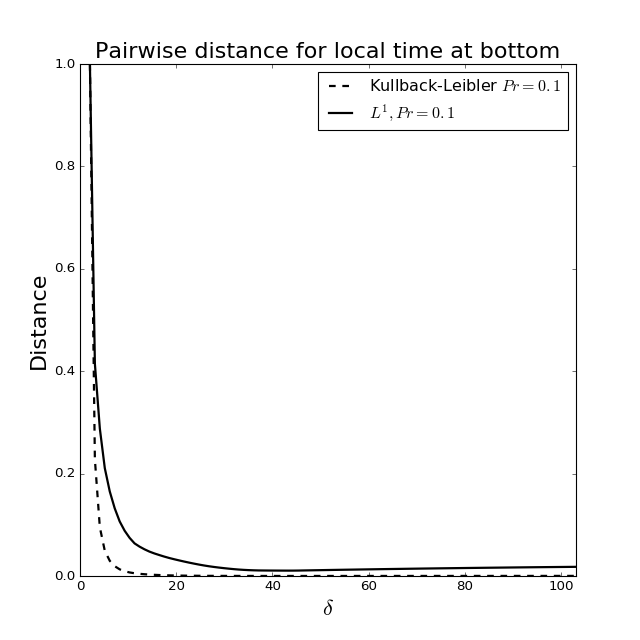

In [5]:
find_opt_delta(space_index = 1, which = 'local time')

<IPython.core.display.Javascript object>


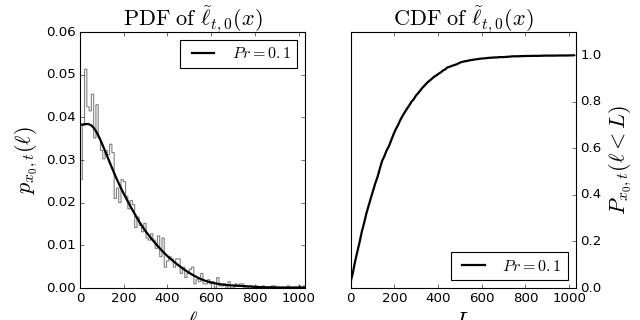

In [6]:
plot_Local_time(space_index = 1, KDE = 'both', include_diff_pdf = 'no')

<IPython.core.display.Javascript object>


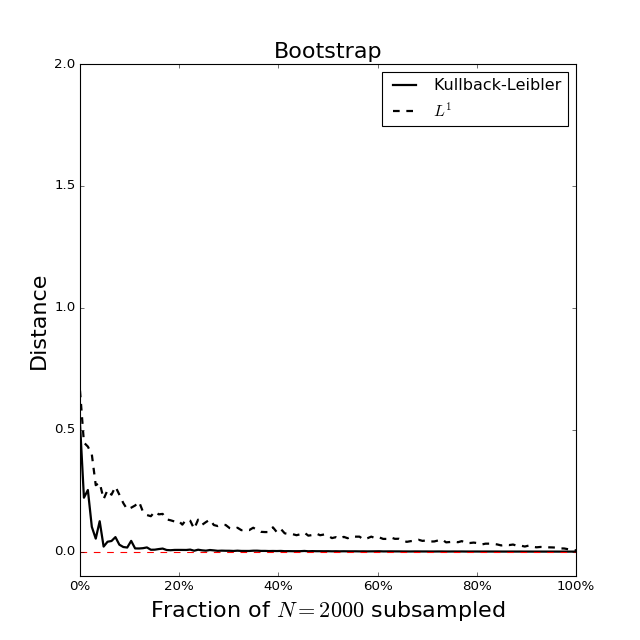

In [14]:
bootstrap_test(delta = 40, space_index = 0,  Nreps = 10)

In [11]:
PrandtlNumbers = np.array([1e0, 1e-1])   
t, x, LT, LB, HT, disp = load_data(npoints = 1, nparticles = 2000, which_database = 'channel')

<IPython.core.display.Javascript object>


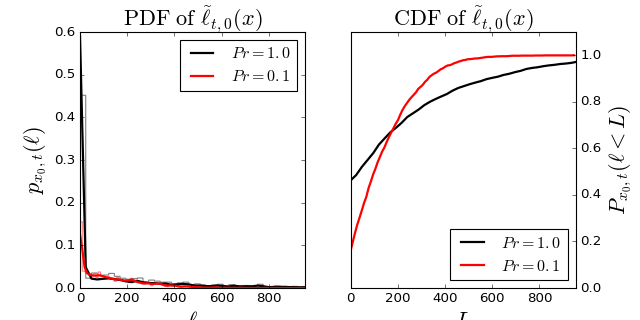

In [12]:
plot_Local_time(space_index = 0, KDE_bandwidth = 10, KDE = 'both', include_diff_pdf = 'no', top_or_bottom = 'bottom')

<IPython.core.display.Javascript object>


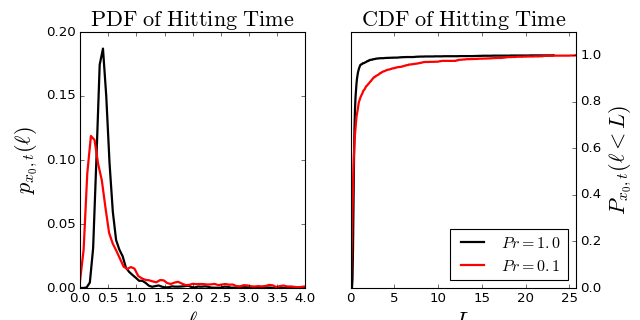

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [13]:
plot_Hitting_time(0, KDE_bandwidth = .04, num_bins = 400)

<IPython.core.display.Javascript object>


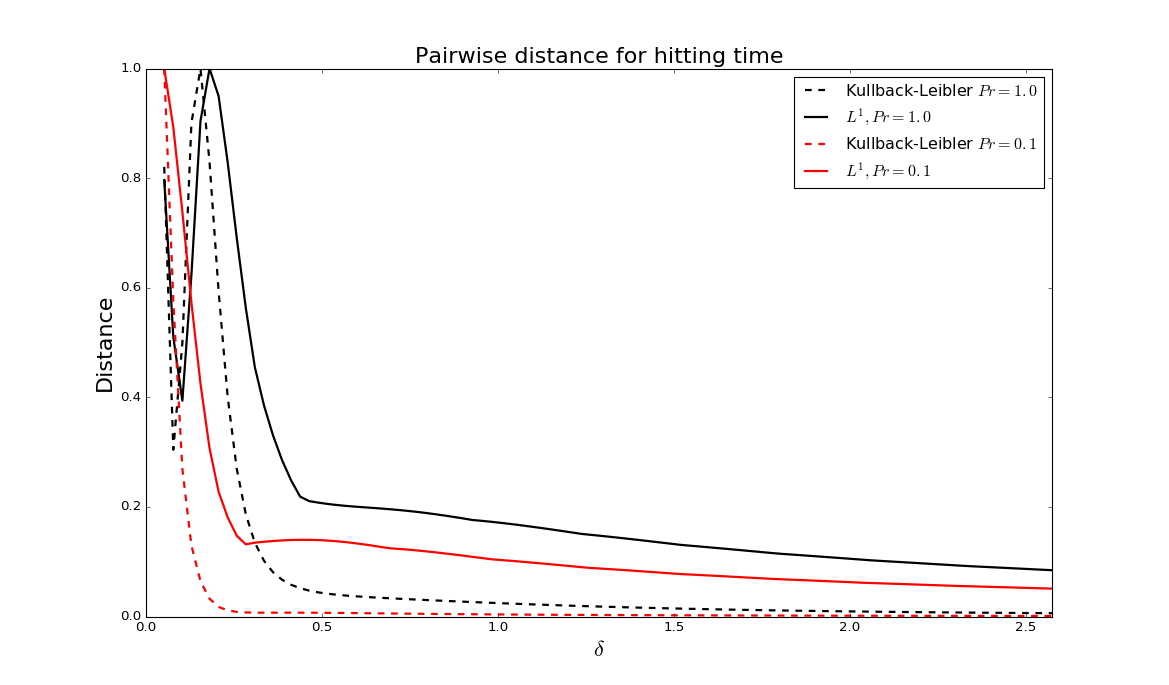

In [14]:
 find_opt_delta(0, which = 'hitting time')

<IPython.core.display.Javascript object>


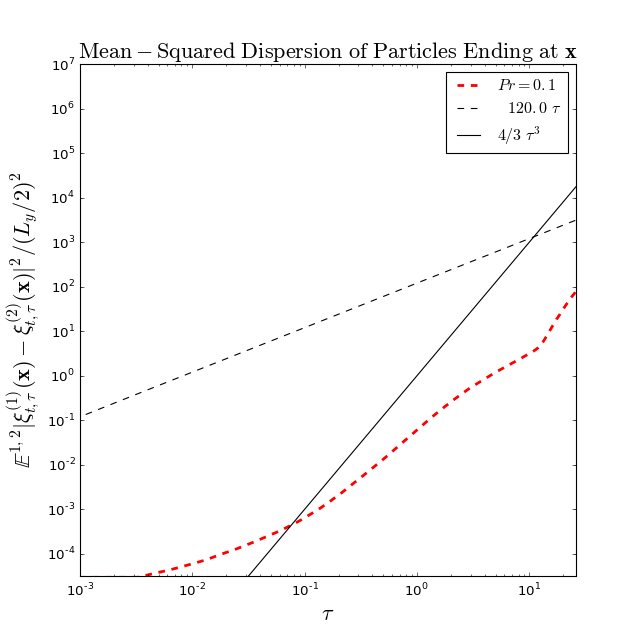

In [9]:
plot_dispersion(0)